In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gc
import os
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
import math
from torch.optim import Adam
from tqdm import tqdm
from models import *
from torchgeo.models import get_weight
from typing import List
from Datasets import *
from utils import *

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

# Optional (for reproducibility in CUDA):
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In DroneClassification/, we have trained ResNet UNet weights on a 3cm/pixel drone dataset

We want to tune the model's decoder weights on our new dataset of 1m/pixel drone images in the process described below.

1. We load in the original model weights trained on 3cm/pixel data as-is and benchmark performance on a 1m/pixel drone dataset vs a 3cm/pixel drone dataset. We expect metrics of the 1m/pixel drone dataset to be bad and metrics of the 3cm/pixel drone dataset to be good

2. We train our ResNet UNet model with 3cm/pixel weights on our 1m/pixel data and visualize the loss curve and evaluation metrics across epochs

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Metal Performance Shaders (MPS) device.\n")
else:
    DEVICE = torch.device("cpu")
    print("WARNING: No GPU found. Defaulting to CPU.")
    
LOSS = JaccardLoss()
BATCH_SIZE = 32
INIT_LR = 0.015
NUM_EPOCHS = 200
DATA_SPLIT = 0.80

ONE_METER_DRONE_IMG_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224dataset_drone.npy'
ONE_METER_DRONE_LABEL_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224dataset_label.npy'
THREE_CM_DRONE_IMG_PATH = '/Users/evanwu/Downloads/Drone Classification/224_image_small.npy'
THREE_CM_DRONE_LABEL_PATH = '/Users/evanwu/Downloads/Drone Classification/224_label_small.npy'

PRETRAINED_RNUN_NOSKIP_PATH = '/Users/evanwu/Downloads/224_moco_resnet18_noskip.pth' # load in center layer from here
PRETRAINED_RNUN_NOSKIP = torch.load(PRETRAINED_RNUN_NOSKIP_PATH, map_location=DEVICE)

PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE = 0.6512
PRETRAINED_RGB_MOCO_WEIGHT_FIRST_VALUE = 0.0596
PRETRAINED_ALL_MOCO_WEIGHT_FIRST_VALUE = 0.0150

# RGB and Satellite metrics
RGB_MEANS = [0.485, 0.456, 0.406]
RGB_SDS = [0.229, 0.224, 0.225]
'''
SATELLITE_MEANS, SATELLITE_SDS = calculate_band_stats(LIST_TILED_SATELLITE_FILE)
SATELLITE_SDS[10] = 1e-6 # So we don't get divide by 0 error during normalization
print(f"SATELLITE_MEANS: {SATELLITE_MEANS}")
print(f"SATELLITE_SDS: {SATELLITE_SDS}")
'''
SATELLITE_MEANS = [0.026770996230905415, 0.09145129995394104, 0.1374701370800858, 0.12629982008698087, 0.08348537283615888, 0.15234747745903673, 0.1755682088182016, 0.19574084608396258, 0.1958724138455955, 0.19676238458042725, 0.0, 0.15115207971951478, 0.0945010388495151]
SATELLITE_SDS = [0.035945900674540114, 0.09533489898570938, 0.1089656215582545, 0.11637876785009475, 0.0598930857979902, 0.10018866040486654, 0.11469476295117267, 0.1271611062494966, 0.1263377774611167, 0.12642673147611674, 1e-06, 0.11149914947615584, 0.07974405349672085]

# reshape and remake means/sds arrays into tensors
RGB_MEANS_TENSOR = torch.tensor(RGB_MEANS, dtype=torch.float32).view(3, 1, 1).to(DEVICE)
RGB_SDS_TENSOR = torch.tensor(RGB_SDS, dtype=torch.float32).view(3, 1, 1).to(DEVICE)
SATELLITE_MEANS_TENSOR = torch.tensor(SATELLITE_MEANS, dtype=torch.float32).view(13, 1, 1).to(DEVICE)
SATELLITE_SDS_TENSOR = torch.tensor(SATELLITE_SDS, dtype=torch.float32).view(13, 1, 1).to(DEVICE)

Using Apple Metal Performance Shaders (MPS) device.



In [3]:
# Training Functions
def train(model, dataset, log_every_x_epochs = 10 , save_model_every_x_epochs = 100):
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()

    save_dir = "decode_tune"
    os.makedirs(save_dir, exist_ok=True)

    opt = Adam(model.parameters(), lr=INIT_LR)
    print("[INFO] training the network...")
    training_loss = []
    all_metrics = []

    # train_ds, valid_ds = dataset.split(DATA_SPLIT)
    n_train = int(len(dataset) * DATA_SPLIT)
    n_val = len(dataset) - n_train

    train_ds, valid_ds = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(1234))
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_train_loss = 0
        
        for batch_idx, (x, y) in enumerate(train_loader):
            # print(f" Batch {batch_idx + 1}/{len(train_loader)}", end="\r")
            
            # Send the input to the device
            x = x.to(DEVICE)
            y = y.float().to(DEVICE)

            # Perform a forward pass and calculate the training loss
            pred = model(x)
            if isinstance(pred, tuple):
                pred = pred[0]
            loss = LOSS(pred, y)

            # Zero out any previously accumulated gradients, perform backpropagation, and update model parameters
            opt.zero_grad()
            loss.backward()
            opt.step()

            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        training_loss.append(avg_train_loss)

        # Evaluate on validation dataset
        metrics = evaluate(model, test_loader)
        all_metrics.append(metrics)
        avg_test_loss = metrics['Loss']

        # Print Epoch Metrics
        if (epoch + 1) % log_every_x_epochs == 0 or epoch == NUM_EPOCHS-1:
          print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}")
          print(f"Train loss: {avg_train_loss:.6f}, Test loss: {avg_test_loss:.4f}")
          print("\nValidation Metrics:")
          for k, v in metrics.items():
              if k != 'Loss':
                  print(f"{k}: {v}")
          print("\n")

        # --- save model checkpoint ---
        if (epoch + 1) % save_model_every_x_epochs == 0 or epoch == NUM_EPOCHS-1:
            # Save model in current directory
            try:
                model_filename = (
                    f"{model.__class__.__name__}_epoch_{epoch+1:06d}.pth"
                )
                save_path = os.path.join(save_dir, model_filename)
                torch.save(model.state_dict(), save_path)
                print(f"Saved model to {save_path}")
            except Exception as exc:
                print(f"Error saving model: {str(exc)}")

        # --- save metrics ---
        if (epoch + 1) % save_model_every_x_epochs == 0 or epoch == NUM_EPOCHS-1:
            train_loss_path = os.path.join(save_dir, "train_losses.npy")
            eval_metrics_path = os.path.join(save_dir, "eval_metrics.npy")
            np.save(train_loss_path, np.array(training_loss, dtype=np.float32))
            np.save(eval_metrics_path, np.array(all_metrics, dtype=object))
            print(f"Saved metrics to {train_loss_path} and {eval_metrics_path}")

    return training_loss, all_metrics

def evaluate(model: nn.Module, dataloader: DataLoader):
    model.eval()
    total_loss = 0
    total_TP = 0
    total_FP = 0
    total_FN = 0
    total_TN = 0

    with torch.no_grad():
        for (x, y) in dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE).float()
            
            pred = model(x)

            if isinstance(pred, tuple):
                pred = pred[0]
            loss = LOSS(pred, y)
            total_loss += loss.item()

            pred = torch.sigmoid(pred).view(-1)
            y = y.view(-1)
            
            TP = (pred * y).sum().item()
            FP = ((1 - y) * pred).sum().item()
            FN = (y * (1 - pred)).sum().item()
            TN = ((1 - y) * (1 - pred)).sum().item()

            total_TP += TP
            total_FP += FP
            total_FN += FN
            total_TN += TN
            
            del x, y, pred, loss

    avg_loss = total_loss / len(dataloader)
    precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    iou = total_TP / (total_TP + total_FP + total_FN) if (total_TP + total_FP + total_FN) > 0 else 0
    accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN) if (total_TP + total_FP + total_FN + total_TN) > 0 else 0
    specificity = total_TN / (total_TN + total_FP) if (total_TN + total_FP) > 0 else 0

    metrics = {
        'Loss': avg_loss,
        'Precision': precision,
        'Recall': recall,
        'f1_score': f1_score,
        'IOU': iou,
        'Accuracy': accuracy,
        'Specificity': specificity
    }

    return metrics

# Plotting functions
def plot_losses(title, training_loss, validation_loss, training_time=None, y_max=0.3):
  # scale losses to fit graph
  valid_loss = [min(x,y_max) for x in validation_loss]
  train_loss = [min(x, y_max) for x in training_loss]

  epochs = len(train_loss)

  plt.figure()
  plt.plot(np.arange(1, epochs+1), train_loss, label="train_loss")
  plt.plot(np.arange(1, epochs+1), valid_loss, label="valid_loss")
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")
  if training_time is not None:
    plt.text(0, 0.3, f"Training Time: {training_time}")

  step = y_max / 10
  yticks = np.arange(0, y_max+step, step)  # Generate ticks from 0.025 to 0.3 with step 0.025
  plt.yticks(yticks)

  max_ticks = 10
  step = max(1, epochs // max_ticks)
  xticks = np.arange(2, epochs+2, step)  # Generate ticks from 0 to num_epochs with step 2
  plt.xticks(xticks)
  
  plt.show()

def plot_metrics(title: str, metric_dict: dict, metrics: List = ['Precision', 'Recall', 'IOU']):
    epochs = len(metric_dict)
    plt.figure()
    for metric in metrics:
        plt.plot(np.arange(0, epochs), [x[metric] for x in metric_dict], label=metric)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend(loc="lower right")

    yticks = np.arange(0.0, 1.1, 0.1)
    plt.yticks(yticks)

    max_ticks = 10
    step = max(1, epochs // max_ticks)
    xticks = np.arange(2, epochs+2, step)
    plt.xticks(xticks)
    
    plt.show()

2. Tune ResNet UNet model on 1mdrone:label pairs

In [4]:
# manually load in all weights from PRETRAINED_RNUN_NOSKIP. Check first weight of encoder and center. Freeze center layer
RNUNNoSkip = ResNet_UNet_NoSkip().to(DEVICE)
RNUNNoSkip.load_state_dict(PRETRAINED_RNUN_NOSKIP)
print("✅ Loaded PRETRAINED_RNUN_NOSKIP weights into RNUNNoSkip")

# freeze center layer weights 
for name, param in RNUNNoSkip.named_parameters():
    if name.startswith('center.'):
        param.requires_grad = False
        print(f"\tFroze weights of {name}")

# check trainable parameters to see if only classification_head weights are trainable
print(f"RNUNNoSkip trainable parameters:")
for name, param in RNUNNoSkip.named_parameters():
    print(f"\t{name:40s}  requires_grad={param.requires_grad}")

loaded_dict = RNUNNoSkip.state_dict()
# sanity check that the first weight value matches for CENTER
assert math.isclose(loaded_dict['center.decoder.0.weight'].flatten()[0].item(), PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE, abs_tol=1e-4), f"first weight from center.decoder.0.weight={loaded_dict['center.decoder.0.weight'].flatten()[0].item()} does not equal PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE={PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE}"
print(loaded_dict['center.decoder.0.weight'].flatten()[0].item() , 'and', PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE)

# sanity check that the first weight value matches for RGB_MOCO
assert math.isclose(loaded_dict['encoder.0.weight'].flatten()[0].item(), PRETRAINED_RGB_MOCO_WEIGHT_FIRST_VALUE, abs_tol=1e-4), f"first weight from center.decoder.0.weight={loaded_dict['encoder.0.weight'].flatten()[0].item()} does not equal PRETRAINED_RGB_MOCO_WEIGHT_FIRST_VALUE={PRETRAINED_RGB_MOCO_WEIGHT_FIRST_VALUE}"
print(loaded_dict['encoder.0.weight'].flatten()[0].item() , 'and', PRETRAINED_RGB_MOCO_WEIGHT_FIRST_VALUE)


# Get evaluation metrics for 1m/pixel drone data
one_meter_drone_dataset = MemmapDataset(images=np.load(ONE_METER_DRONE_IMG_PATH, 'r'), labels=np.load(ONE_METER_DRONE_LABEL_PATH, 'r'), rgb_means=RGB_MEANS, rgb_sds=RGB_SDS, satellite_means=SATELLITE_MEANS, satellite_sds=SATELLITE_SDS)
print(f"one_meter_drone_dataset containing {len(one_meter_drone_dataset)} images loaded.")
one_meter_drone_loader = DataLoader(one_meter_drone_dataset, batch_size=BATCH_SIZE, shuffle=False)
one_meter_drone_metrics = evaluate(RNUNNoSkip, one_meter_drone_loader)
print(f"one_meter_drone metrics on RNUNNoSkip: {one_meter_drone_metrics}")

# Get evaluation metrics for 3cm/pixel drone data
three_cm_drone_dataset = MemmapDataset(images=np.load(THREE_CM_DRONE_IMG_PATH, 'r'), labels=np.load(THREE_CM_DRONE_LABEL_PATH, 'r'), rgb_means=RGB_MEANS, rgb_sds=RGB_SDS, satellite_means=SATELLITE_MEANS, satellite_sds=SATELLITE_SDS)
print(f"three_cm_drone_dataset containing {len(three_cm_drone_dataset)} images loaded.")
three_cm_drone_loader = DataLoader(three_cm_drone_dataset, batch_size=BATCH_SIZE, shuffle=False)
three_cm_drone_metrics = evaluate(RNUNNoSkip, three_cm_drone_loader)
print(f"three_cm_drone_metrics on RNUNNoSkip: {three_cm_drone_metrics}")

del RNUNNoSkip
gc.collect()


✅ Loaded PRETRAINED_RNUN_NOSKIP weights into RNUNNoSkip
	Froze weights of center.decoder.0.weight
	Froze weights of center.decoder.0.bias
	Froze weights of center.decoder.1.weight
	Froze weights of center.decoder.1.bias
	Froze weights of center.decoder.4.weight
	Froze weights of center.decoder.4.bias
	Froze weights of center.decoder.5.weight
	Froze weights of center.decoder.5.bias
	Froze weights of center.decoder.7.weight
	Froze weights of center.decoder.7.bias
RNUNNoSkip trainable parameters:
	encoder.0.weight                          requires_grad=False
	encoder.1.weight                          requires_grad=False
	encoder.1.bias                            requires_grad=False
	encoder.4.0.conv1.weight                  requires_grad=False
	encoder.4.0.bn1.weight                    requires_grad=False
	encoder.4.0.bn1.bias                      requires_grad=False
	encoder.4.0.conv2.weight                  requires_grad=False
	encoder.4.0.bn2.weight                    requires_grad=Fal

52

In [5]:
# manually load in all weights from PRETRAINED_RNUN_NOSKIP. Check first weight of encoder and center. Freeze center layer
RNUNNoSkip = ResNet_UNet_NoSkip().to(DEVICE)
RNUNNoSkip.load_state_dict(PRETRAINED_RNUN_NOSKIP)
print("✅ Loaded PRETRAINED_RNUN_NOSKIP weights into RNUNNoSkip")

# freeze center layer weights 
# for name, param in RNUNNoSkip.named_parameters():
#     if name.startswith('center.'):
#         param.requires_grad = False
#         print(f"\tFroze weights of {name}")

# check trainable parameters to see if only classification_head weights are trainable
print(f"RNUNNoSkip trainable parameters:")
for name, param in RNUNNoSkip.named_parameters():
    print(f"\t{name:40s}  requires_grad={param.requires_grad}")

loaded_dict = RNUNNoSkip.state_dict()
# sanity check that the first weight value matches for CENTER
assert math.isclose(loaded_dict['center.decoder.0.weight'].flatten()[0].item(), PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE, abs_tol=1e-4), f"first weight from center.decoder.0.weight={loaded_dict['center.decoder.0.weight'].flatten()[0].item()} does not equal PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE={PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE}"
print(loaded_dict['center.decoder.0.weight'].flatten()[0].item() , 'and', PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE)

# sanity check that the first weight value matches for RGB_MOCO
assert math.isclose(loaded_dict['encoder.0.weight'].flatten()[0].item(), PRETRAINED_RGB_MOCO_WEIGHT_FIRST_VALUE, abs_tol=1e-4), f"first weight from center.decoder.0.weight={loaded_dict['encoder.0.weight'].flatten()[0].item()} does not equal PRETRAINED_RGB_MOCO_WEIGHT_FIRST_VALUE={PRETRAINED_RGB_MOCO_WEIGHT_FIRST_VALUE}"
print(loaded_dict['encoder.0.weight'].flatten()[0].item() , 'and', PRETRAINED_RGB_MOCO_WEIGHT_FIRST_VALUE)

one_meter_drone_dataset = MemmapDataset(images=np.load(ONE_METER_DRONE_IMG_PATH, 'r'), labels=np.load(ONE_METER_DRONE_LABEL_PATH, 'r'), rgb_means=RGB_MEANS, rgb_sds=RGB_SDS, satellite_means=SATELLITE_MEANS, satellite_sds=SATELLITE_SDS)
print(f"one_meter_drone_dataset containing {len(one_meter_drone_dataset)} images loaded.")

train_loss, valid_metrics = train(RNUNNoSkip, one_meter_drone_dataset, save_model_every_x_epochs = 100)

del RNUNNoSkip
gc.collect()


✅ Loaded PRETRAINED_RNUN_NOSKIP weights into RNUNNoSkip
RNUNNoSkip trainable parameters:
	encoder.0.weight                          requires_grad=False
	encoder.1.weight                          requires_grad=False
	encoder.1.bias                            requires_grad=False
	encoder.4.0.conv1.weight                  requires_grad=False
	encoder.4.0.bn1.weight                    requires_grad=False
	encoder.4.0.bn1.bias                      requires_grad=False
	encoder.4.0.conv2.weight                  requires_grad=False
	encoder.4.0.bn2.weight                    requires_grad=False
	encoder.4.0.bn2.bias                      requires_grad=False
	encoder.4.1.conv1.weight                  requires_grad=False
	encoder.4.1.bn1.weight                    requires_grad=False
	encoder.4.1.bn1.bias                      requires_grad=False
	encoder.4.1.conv2.weight                  requires_grad=False
	encoder.4.1.bn2.weight                    requires_grad=False
	encoder.4.1.bn2.bias        

232

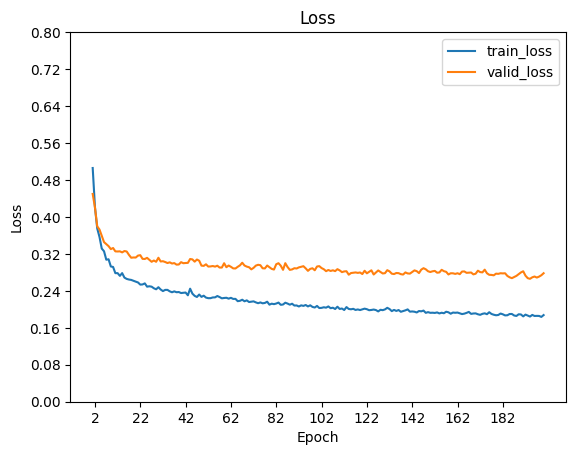

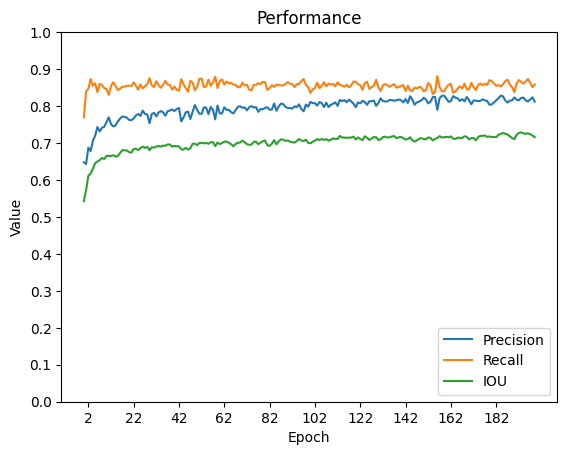

In [6]:
loaded_train_losses = np.load("decode_tune/train_losses.npy")
loaded_eval_metrics = np.load("decode_tune/eval_metrics.npy", allow_pickle=True)
loaded_eval_losses = [m['Loss'] for m in loaded_eval_metrics]

plot_losses("Loss", loaded_train_losses, loaded_eval_losses, y_max=0.8)
plot_metrics("Performance", loaded_eval_metrics)

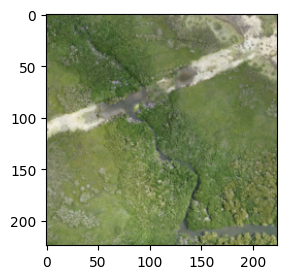

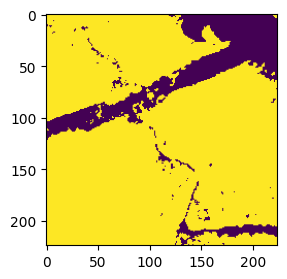

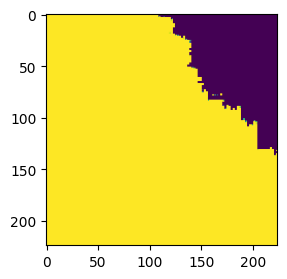

In [17]:
# visualize predictions with tuned model. compares img : gt: pred
one_meter_drone_dataset = MemmapDataset(images=np.load(ONE_METER_DRONE_IMG_PATH, 'r'), labels=np.load(ONE_METER_DRONE_LABEL_PATH, 'r'), rgb_means=RGB_MEANS, rgb_sds=RGB_SDS, satellite_means=SATELLITE_MEANS, satellite_sds=SATELLITE_SDS)
idx = 8

TUNED_RNUN_NOSKIP_PATH = '/Users/evanwu/Downloads/finat2_200.pth'
TUNED_RNUN_NOSKIP = torch.load(TUNED_RNUN_NOSKIP_PATH, map_location=DEVICE)
tuned_RNUNNoSkip = ResNet_UNet_NoSkip()
tuned_RNUNNoSkip.load_state_dict(TUNED_RNUN_NOSKIP)
tuned_RNUNNoSkip.to(DEVICE)

tuned_RNUNNoSkip.eval()
with torch.no_grad():
  img, label = one_meter_drone_dataset[idx]
  plot_img_gt_pred(img.to(DEVICE), label.to(DEVICE), tuned_RNUNNoSkip(torch.unsqueeze(img, 0).to(DEVICE)), rgb_mean_tensor=RGB_MEANS_TENSOR, rgb_std_tensor=RGB_SDS_TENSOR, satellite_mean_tensor=SATELLITE_MEANS_TENSOR, satellite_std_tensor=SATELLITE_SDS_TENSOR)

{-574: 1, -557: 1, -494: 1, -485: 1, -464: 1, -456: 1, -455: 1, -450: 1, -440: 1, -419: 1, -398: 1, -382: 1, -375: 1, -370: 1, -367: 1, -362: 1, -361: 1, -360: 1, -358: 1, -354: 1, -353: 1, -351: 1, -350: 1, -347: 1, -346: 1, -344: 1, -341: 1, -339: 1, -337: 1, -336: 1, -334: 1, -333: 1, -332: 1, -331: 1, -330: 1, -329: 1, -326: 1, -325: 1, -323: 1, -322: 1, -321: 1, -320: 1, -319: 1, -317: 1, -316: 1, -315: 1, -314: 1, -313: 1, -312: 1, -311: 1, -310: 1, -308: 1, -307: 1, -306: 1, -305: 1, -304: 1, -303: 1, -302: 1, -301: 1, -300: 1, -299: 1, -298: 1, -297: 1, -296: 1, -295: 1, -294: 1, -293: 1, -292: 1, -291: 1, -290: 1, -288: 1, -287: 1, -286: 1, -285: 1, -284: 1, -283: 1, -282: 1, -281: 1, -280: 1, -279: 1, -278: 1, -277: 1, -276: 1, -275: 1, -274: 1, -273: 1, -272: 1, -271: 1, -270: 1, -269: 1, -268: 1, -267: 1, -266: 1, -265: 1, -264: 1, -263: 1, -262: 1, -261: 1, -260: 1, -259: 1, -258: 1, -257: 1, -256: 1, -255: 1, -254: 1, -253: 1, -252: 1, -251: 1, -250: 1, -249: 1, -248: 1, 

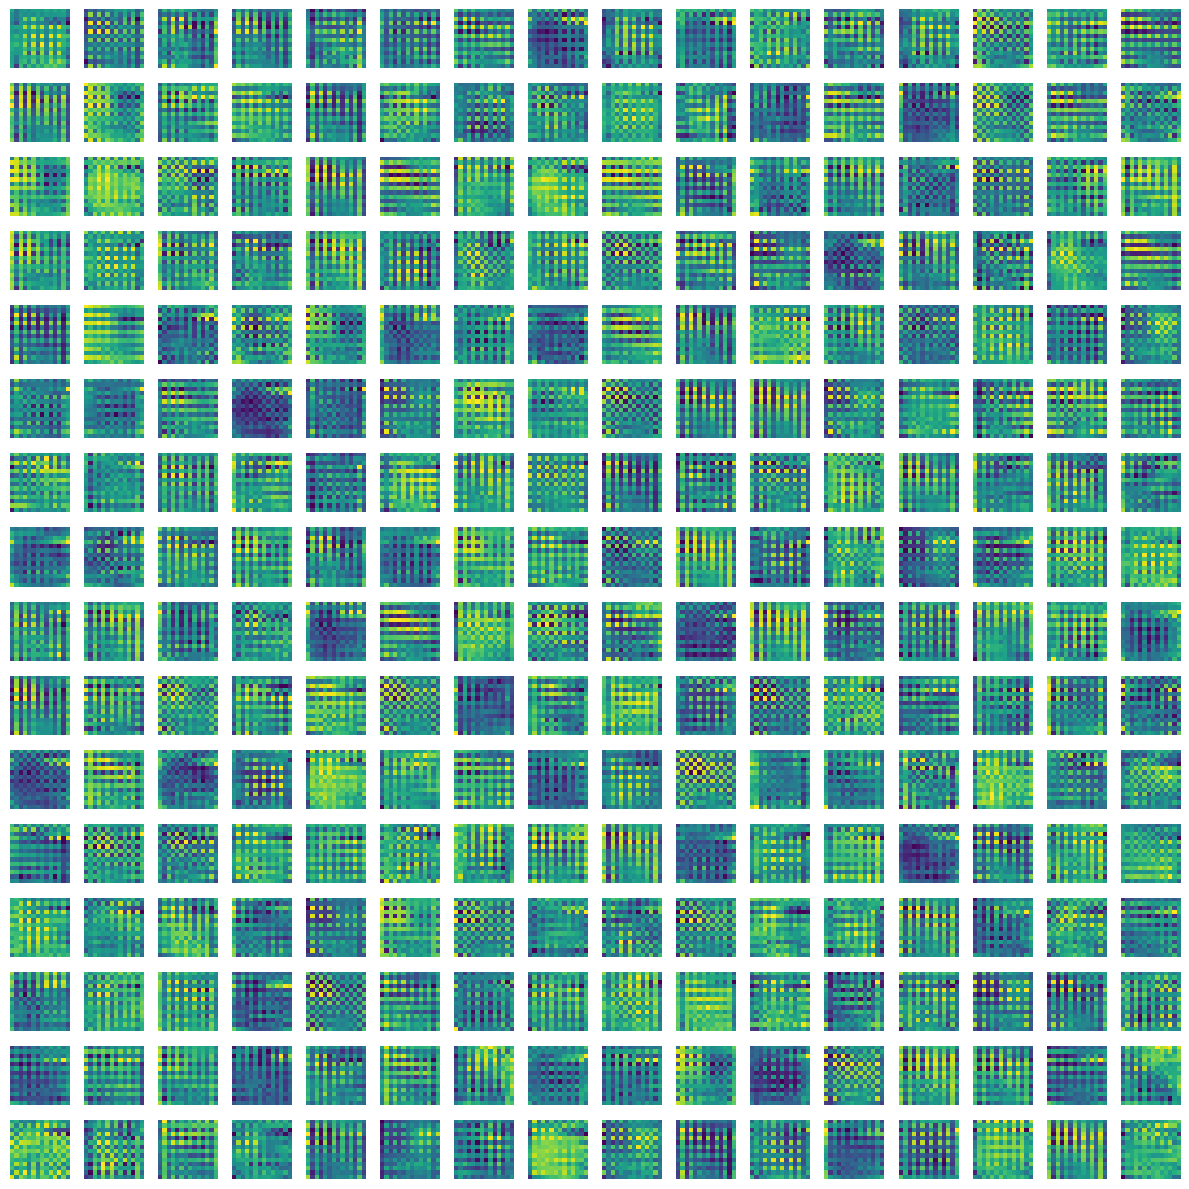

In [8]:
img, label = one_meter_drone_dataset[idx]

tuned_RNUNNoSkip.eval()
with torch.no_grad():
  latent = tuned_RNUNNoSkip.center(tuned_RNUNNoSkip.encoder(torch.unsqueeze(img, 0).to(DEVICE)))
  print(pixel_value_counts(latent.cpu()))
plot_latent_space(latent.squeeze())